In [ ]:
# ========================================
# 1. Install package
# ========================================
!pip install -q transformers datasets sentencepiece accelerate evaluate
!pip install -q fsspec==2023.6.0

In [ ]:
!pip install -U --quiet transformers==4.40.1

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=216bf6b38ce4d107495708053b816e8448e66d5c918b4330b65947a9452f4344
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
# ========================================
# 2. Import library
# ========================================
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from tqdm import tqdm

# ========================================
# 3. Load dataset DialogSum
# ========================================
dataset = load_dataset("knkarthick/dialogsum")
train_data = dataset["train"]
val_data = dataset["validation"]

# ========================================
# 4. Load tokenizer dan model FLAN-T5
# ========================================
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ========================================
# 5. Tokenisasi dataset
# ========================================
max_input_len = 512
max_target_len = 128

def tokenize(example):
    input_text = "summarize: " + example["dialogue"]
    input_enc = tokenizer(
        input_text, max_length=max_input_len, truncation=True, padding="max_length"
    )
    target_enc = tokenizer(
        example["summary"], max_length=max_target_len, truncation=True, padding="max_length"
    )
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

train_dataset = train_data.map(tokenize)
val_dataset = val_data.map(tokenize)

columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# ========================================
# 6. Optimizer
# ========================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# ========================================
# 7. Training Loop
# ========================================
epochs = 20

model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

# ========================================
# 8. Tes 1 Sample
# ========================================
model.eval()
sample = dataset["test"][0]
input_text = "summarize: " + sample["dialogue"]
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
summary_ids = model.generate(**inputs, max_length=128)
print("Generated Summary:\n", tokenizer.decode(summary_ids[0], skip_special_tokens=True))
print("\nReference Summary:\n", sample["summary"])


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Epoch 1/20


Epoch 1: 100%|██████████| 250/250 [02:58<00:00,  1.40it/s, loss=0.516]


Epoch 2/20


Epoch 2: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.323]


Epoch 3/20


Epoch 3: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.369]


Epoch 4/20


Epoch 4: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.43]


Epoch 5/20


Epoch 5: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.393]


Epoch 6/20


Epoch 6: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.168]


Epoch 7/20


Epoch 7: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.437]


Epoch 8/20


Epoch 8: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.334]


Epoch 9/20


Epoch 9: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.288]


Epoch 10/20


Epoch 10: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.308]


Epoch 11/20


Epoch 11: 100%|██████████| 250/250 [03:00<00:00,  1.39it/s, loss=0.224]


Epoch 12/20


Epoch 12: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.298]


Epoch 13/20


Epoch 13: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.349]


Epoch 14/20


Epoch 14: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.19]


Epoch 15/20


Epoch 15: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.104]


Epoch 16/20


Epoch 16: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.204]


Epoch 17/20


Epoch 17: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.226]


Epoch 18/20


Epoch 18: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.183]


Epoch 19/20


Epoch 19: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.0948]


Epoch 20/20


Epoch 20: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s, loss=0.11]


Generated Summary:
 #Person1# asks Ms. Dawson to take a dictation for him. Ms. Dawson says all office communications are restricted to email correspondence and official memos. The memo also applies to external communications, and any employee who persists in using Instant Messaging will be placed on probation.

Reference Summary:
 Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.


In [ ]:
save_path = "/content/drive/MyDrive/flan-t5-dialogsum-finetuned"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/flan-t5-dialogsum-finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/flan-t5-dialogsum-finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/flan-t5-dialogsum-finetuned/spiece.model',
 '/content/drive/MyDrive/flan-t5-dialogsum-finetuned/added_tokens.json',
 '/content/drive/MyDrive/flan-t5-dialogsum-finetuned/tokenizer.json')

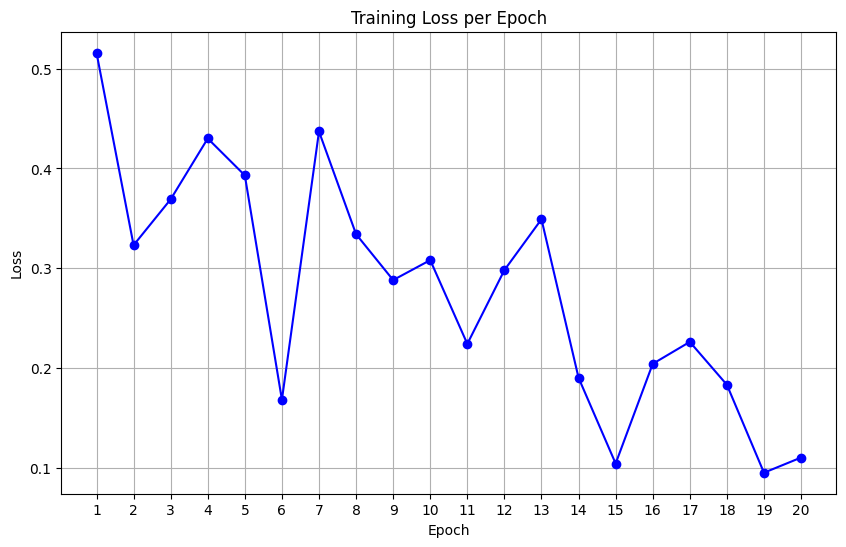

In [ ]:
import matplotlib.pyplot as plt

# Data loss yang diekstrak dari output notebook
epochs = range(1, 21)
loss_values = [
    0.516, 0.323, 0.369, 0.430, 0.393, 0.168, 0.437, 0.334, 0.288, 0.308,
    0.224, 0.298, 0.349, 0.190, 0.104, 0.204, 0.226, 0.183, 0.0948, 0.110
]

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')

# Menambahkan judul dan label
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)

# Menampilkan plot
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

load_path = "/content/drive/MyDrive/flan-t5-dialogsum-finetuned"  # atau path dari Google Drive

tokenizer = AutoTokenizer.from_pretrained(load_path)
model = AutoModelForSeq2SeqLM.from_pretrained(load_path, trust_remote_code=True, from_safetensors=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
input_dialog = """\
A: Hey, are you free for a bit? I wanted to go over the client feedback from yesterday.
B: Sure, what did they say?
A: Well, overall they were happy with the direction of the app redesign, but they had quite a few comments about the user onboarding flow.
B: I figured that might come up. Was it about the tutorial screens again?
A: Yes, partly. They said the tutorial was too long and some users dropped off before completing it.
B: Hmm, maybe we should shorten it or make it skippable.
A: That’s exactly what they suggested. Also, they were confused about the payment process—especially the subscription screen.
B: That’s not surprising. The current flow has two modals and a confirmation screen. It’s too much.
A: I agree. They also mentioned that the pricing tiers weren’t clearly explained.
B: Did they give any specific suggestions?
A: They asked us to consider using simpler language and maybe even adding a short video explanation.
B: Interesting. We could test a collapsible FAQ or a short explainer video. What else?
A: They liked the new dashboard layout but said that the analytics charts load too slowly on mobile.
B: That’s a backend issue, probably due to the API calls not being optimized.
A: Can you talk to DevOps about that?
B: Yep, I’ll ping them this afternoon.
A: Another thing—they had trouble finding the customer support link.
B: I thought we moved that to the settings menu?
A: We did, but apparently users don’t expect it there. Maybe we can try putting a help icon on the main nav bar.
B: Makes sense. I’ll mock that up and show you later.
A: Oh, and they also mentioned that the app feels a bit slow overall.
B: Probably a combination of animation delay and image sizes. I can profile the performance again.
A: Great. They were still very positive though—just want it more polished.
B: That's good to hear. So action items: I’ll review the onboarding flow, check performance, talk to DevOps, and redesign the help access.
A: Exactly. I’ll follow up with a summary email. Thanks for jumping on this!
B: Anytime.
"""

# 1. Tambahkan prefix 'summarize: '
input_text = "summarize: " + input_dialog

# 2. Tokenisasi input
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

# 3. Generate summary
summary_ids = model.generate(**inputs, max_new_tokens=128)

# 4. Decode output
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Summary:", summary)

Summary: A wants to go over the client feedback from yesterday and asks B to shorten the tutorial, make it skippable, and introduce a short video explanation of the tutorial. A also wants to change the customer support link and introduce it to DevOps. A will check the performance and redesign the help access.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
